In [1]:
import sys
import argparse
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from metadata.const import features, class_label

In [2]:
def get_config(section):
    config = configparser.RawConfigParser()
    config.read('../settings.ini')
    return dict(config.items(section))

In [3]:
def remove_zero_variance(df, features):
    const_filter = VarianceThreshold()
    const_filter.fit(df)
    cols = const_filter.get_support(indices=True)
    return df.iloc[:, cols]

In [4]:
def plot_correlation(correlation, filename, save=True, labels=None):
    fig = plt.figure(figsize=(10.41, 7.29))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1)
    fig.colorbar(cax)
    if labels:
        ticks = np.arange(0, len(labels), 1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
                rotation_mode="anchor")
    if save:
        plt.savefig(filename)
    else:
        plt.show()

In [5]:
filename = 'sample-200000.csv'
df = pd.read_csv(f'../dataset/{filename}', dtype={features['similar_http']: str})
df.drop(
    [
        features['unnamed0'],
        features['flow_id'],
        features['source_ip'],
        features['source_port'],
        features['destination_ip'],
        features['destination_port'],
        features['timestamp'],
        features['similar_http'],
    ],
    axis=1,
    inplace=True
)

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, inplace=True)

In [7]:
categorical_features = [features['protocol'], features['inbound']]
numeric_features = [f for f in df.columns
                        if f not in categorical_features]

In [8]:
df.loc[df[class_label] == 'BENIGN', class_label] = 0
df.loc[df[class_label] != 0, class_label] = 1

In [9]:
df = remove_zero_variance(df, numeric_features)

In [10]:
numeric_df = df.drop(categorical_features, axis=1)
corr_matrix = numeric_df.corr(method='pearson')

In [11]:
redundent_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            redundent_features.add(corr_matrix.columns[i])

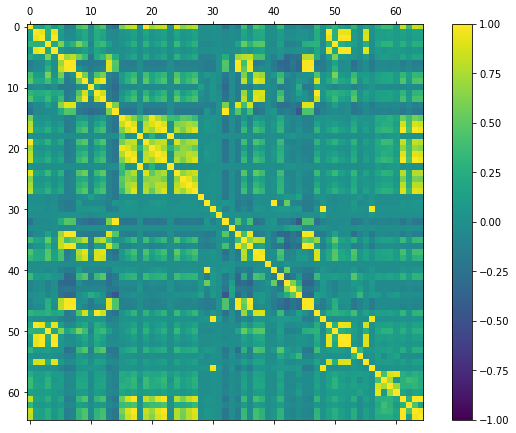

In [13]:
plot_correlation(
    corr_matrix,
    'numeric-correlation.png',
    save=False
#     labels=numeric_df.columns.to_list()
)

In [14]:
df.drop(list(redundent_features), axis=True, inplace=True)
df.to_csv(f'clean-{filename}', index=False)